<a href="https://colab.research.google.com/github/DevinB64/BAIS-9010-Final-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load Packages #

In [15]:
import tensorflow_hub as hub
import tensorflow as tf

import imblearn
from imblearn.over_sampling import SMOTE

# import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()

import sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_datasets as tfds

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import os
import gzip
import json
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from google.colab import files
path = files.upload()

Saving video_game_data.gz to video_game_data (1).gz


Load in the review data

In [9]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('video_game_data.gz')

In [10]:
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
497572,4.0,True,"07 1, 2017",AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts,Four Stars,1498867200,NaN,NaN,NaN
497573,3.0,True,"08 20, 2018",A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.,Three Stars,1534723200,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497574,3.0,True,"08 7, 2017",ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...,Only buy on sale.,1502064000,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497575,4.0,False,"08 5, 2018",A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...,"It's Okay, Nothing Profound",1533427200,NaN,"{'Edition:': ' Collection', 'Platform:': ' Xbo...",NaN


Check the distribution of the reviews - we will use SMOTE to correct the imbalanced reviews

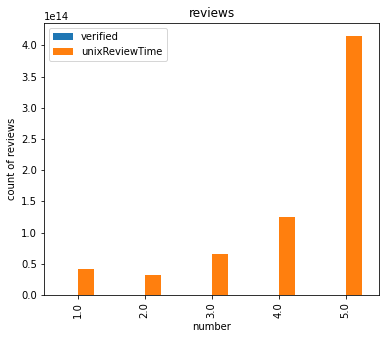

In [11]:
dfg = df.groupby(['overall']).sum()

dfg.plot(kind='bar', title='reviews', ylabel='count of reviews',
         xlabel='number', figsize=(6, 5))

In [ ]:
#declare inputs and target
inputs=df['reviewText']
target=df['overall']
from sklearn.model_selection import train_test_split
#train test split dataset 
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=.2, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(x_train.values.astype('U'))
x_train=vectorizer.transform(x_train.values.ravel())
x_test=vectorizer.transform(x_test.values.ravel())
x_train=x_train.toarray()
x_test=x_test.toarray()


In [ ]:
oversample = SMOTE()
x_train, y_train = oversample.fit_sample(x_train, y_train)

Remove any null reviews

In [10]:
df = df.dropna(subset = ["reviewText"])
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText             0
summary              103
unixReviewTime         0
vote              389635
style             208296
image             493819
dtype: int64

In [11]:
reviews = df['reviewText']
reviews = reviews.tolist()


# Preprocessing #

In [12]:
reviews_cleaned = list()

for review in reviews:
    tokens = word_tokenize(review) # Tokenize each sentence in the list
    tokens = [word.lower() for word in tokens] # List comprehension - make each word lowercase in each sentence
    table = str.maketrans('' , '' , string.punctuation) # Here I am creating a byte mapping table for the puncutation group from the string package
    stripped = [ w.translate(table) for w in tokens] # Apply the mapping table to the characters in each of our tokens
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    reviews_cleaned.append(words)



In [13]:
common = nltk.FreqDist(i for sentences in reviews_cleaned for i in sentences) # access each tokenized word in each sentence and run a frequency distribution

In [14]:
mostCommon= common.most_common(10) # list the most frequent words from our reviews
mostCommon

[('game', 1008948),
 ('nt', 415613),
 ('like', 286500),
 ('one', 253547),
 ('games', 244205),
 ('get', 211090),
 ('play', 202525),
 ('great', 196225),
 ('good', 188775),
 ('really', 161170)]

### None of these words look out of the ordinary so far, so we won't remove any words or word trends for now ###

# Bigram collocations: #

In [15]:
phrases = Phrases(reviews_cleaned)

In [16]:
bigram = Phraser(phrases)

In [17]:
bigram.phrasegrams

{(b'get', b'hang'): (1668, 19.580332589270075),
 (b'looking', b'forward'): (2833, 72.20502938230523),
 (b'verry', b'good'): (56, 14.327420604822272),
 (b'avid', b'gamer'): (292, 149.85411384884864),
 (b'work', b'properly'): (393, 19.536001228484718),
 (b'incredibly', b'frustrating'): (230, 20.714249988231416),
 (b'massive', b'amounts'): (134, 151.0730484646689),
 (b'sad', b'sad'): (45, 22.27026975437831),
 (b'pretty', b'cool'): (3144, 12.631136051368891),
 (b'boy', b'wrong'): (246, 19.189913476926172),
 (b'takes', b'forever'): (707, 57.04867615304691),
 (b'create', b'account'): (84, 16.670201092074176),
 (b'right', b'bat'): (677, 65.18907064569396),
 (b'ever', b'played'): (7369, 15.719036195710322),
 (b'sim', b'city'): (513, 40.64788469547843),
 (b'layers', b'complexity'): (8, 74.05165566516757),
 (b'previous', b'versions'): (850, 44.286684744331495),
 (b'requires', b'internet'): (113, 20.50495477277801),
 (b'internet', b'connection'): (1401, 272.81573795434247),
 (b'spent', b'hours'):

In [18]:
#max_vocab_size can be used instead of min_count (which has increased here)
model = Word2Vec(sentences=reviews_cleaned, size=64, 
                 sg=1, window=10, iter=5,
                 min_count=10, workers=4)
model.save('clean_amazon_reviews_model.w2v')

In [27]:
model = gensim.models.Word2Vec.load('clean_amazon_reviews_model.w2v') 

In [28]:
len(model.wv.vocab)

41483

In [33]:
model.wv.most_similar('game', topn=10)

[('play', 0.8059132099151611),
 ('games', 0.7990384697914124),
 ('fun', 0.7936830520629883),
 ('really', 0.7661912441253662),
 ('still', 0.7477391958236694),
 ('played', 0.7400131225585938),
 ('playing', 0.7335811853408813),
 ('graphics', 0.7211914658546448),
 ('good', 0.7202790975570679),
 ('time', 0.7159019112586975)]

In [36]:
tsne = TSNE(n_components=2, n_iter=1000)

In [37]:
X_2d = tsne.fit_transform(model.wv[model.wv.vocab])

In [38]:
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.vocab.keys()

In [39]:
coords_df.head()

,x,y,token
0,23.714888,-9.121043,game
1,24.054541,-9.858598,bit
2,1.075234,-6.720605,hard
3,25.416273,-11.505931,get
4,4.911378,-15.205656,hang


In [40]:
coords_df.to_csv('clean_amazon_reviews_tsne.csv', index=False)

In [41]:
coords_df = pd.read_csv('clean_amazon_reviews_tsne.csv')

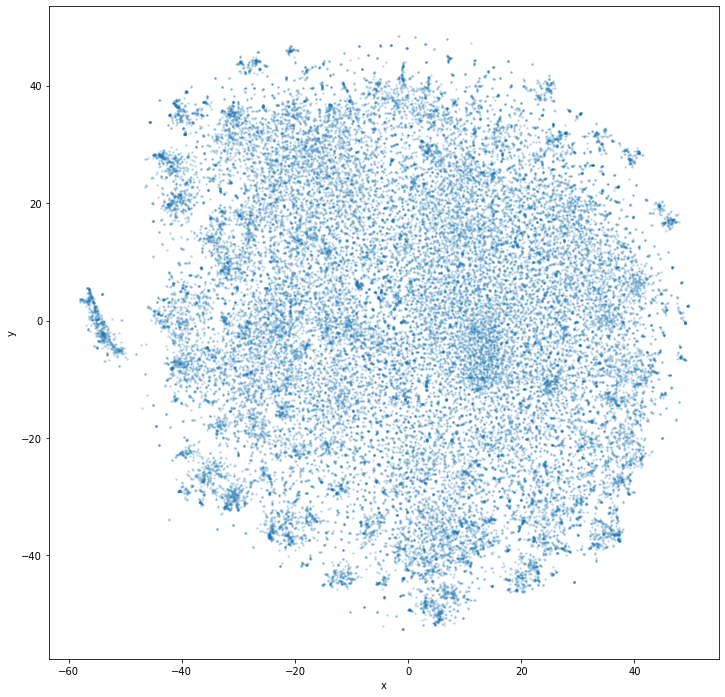

In [42]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), 
                           marker='.', s=10, alpha=0.2)